In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cPickle as pickle
%matplotlib inline

from lasagnekit.misc.draw_net import draw_to_notebook, draw_to_file
from lasagnekit.misc.plot_weights import grid_plot
from lasagnekit.misc.dream import build_dreamer
from lasagnekit.easy import LightweightModel, BatchOptimizer

from lasagne import layers, updates

from IPython.display import SVG

import theano
import theano.tensor as T

from skimage.io import imread
from skimage.transform import resize

from lasagnekit.easy import get_stat

import matplotlib.pyplot as plt

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m (CNMeM is disabled)


In [2]:
IMAGE_W = 224
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = resize(im, (IMAGE_W, w*IMAGE_W/h), preserve_range=True)
    else:
        im = resize(im, (h*IMAGE_W/w, IMAGE_W), preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_W//2:h//2+IMAGE_W//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, (im[np.newaxis]).astype(np.float32)

In [3]:
data = pickle.load(open("vgg19-lasagne.pkl"))

In [4]:
print(data.keys())

['classes', 'model', 'mean_value']


In [5]:
model = data["model"]
classes = np.array(data["classes"])
mean_value = data["mean_value"]

In [6]:
model.keys()

['input',
 'conv1_1',
 'conv1_2',
 'pool1',
 'conv2_1',
 'conv2_2',
 'pool2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'conv3_4',
 'pool3',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'conv4_4',
 'pool4',
 'conv5_1',
 'conv5_2',
 'conv5_3',
 'conv5_4',
 'pool5',
 'fc6',
 'fc7',
 'fc8',
 'prob']

In [7]:
draw_to_file(layers.get_all_layers(model['prob']), "vgg.svg")

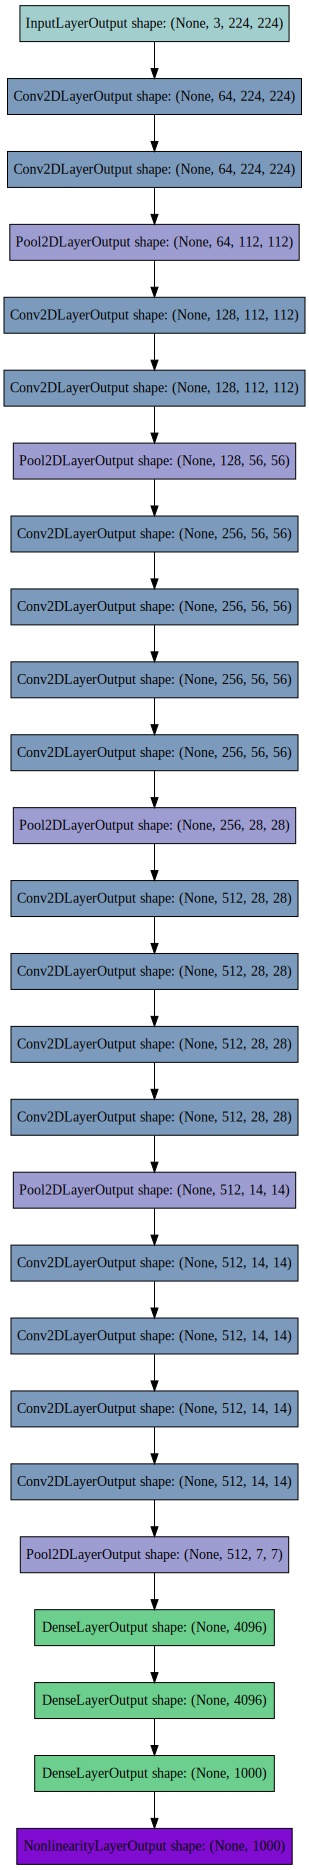

In [8]:
SVG("vgg.svg")

In [9]:
X_batch = theano.tensor.tensor4()
predict = theano.function([X_batch], layers.get_output(model["prob"], X_batch))
pre_predict = theano.function([X_batch], layers.get_output(model["fc8"], X_batch))


In [10]:
!wget http://www.hdwallpapers.in/walls/great_sword-wide.jpg --output-document=sample.png

--2015-09-08 12:13:29--  http://www.hdwallpapers.in/walls/great_sword-wide.jpg
Resolving www.hdwallpapers.in... 72.55.180.216
Connecting to www.hdwallpapers.in|72.55.180.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104163 (102K) [image/jpeg]
Saving to: “sample.png”

100%[======================================>] 104,163      222K/s   in 0.5s    

2015-09-08 12:13:30 (222 KB/s) - “sample.png” saved [104163/104163]



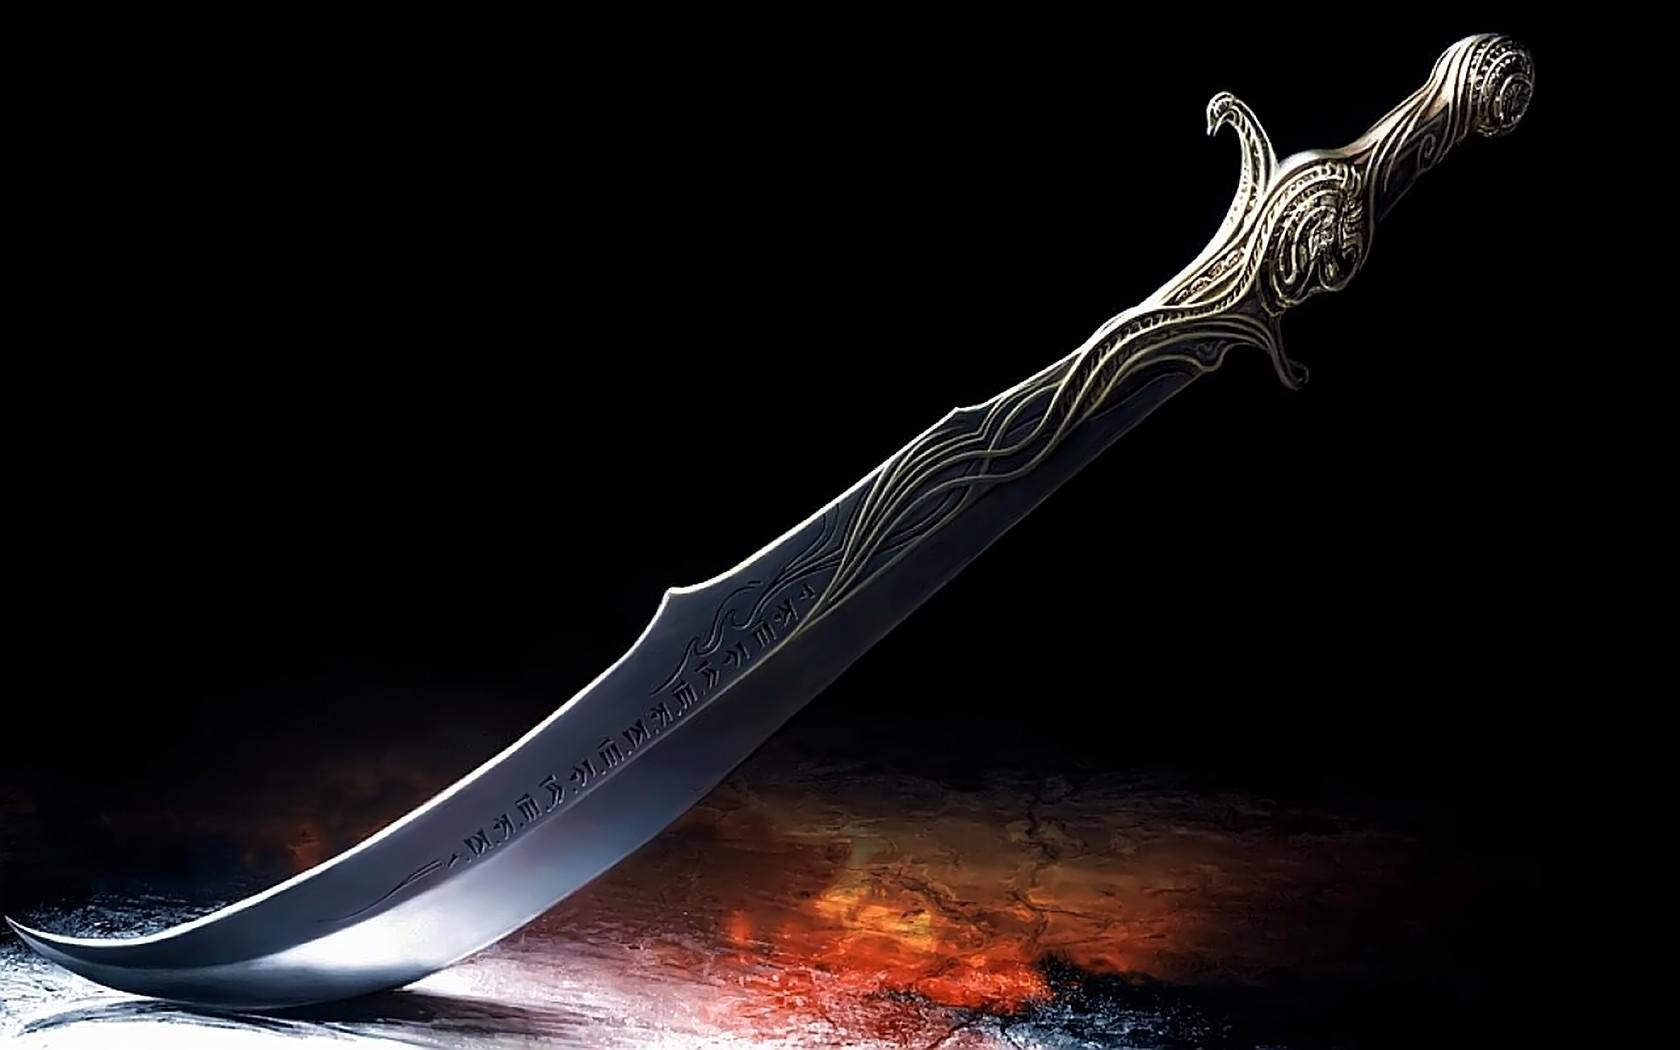

In [11]:
from IPython.display import Image
img = Image("sample.png")
img

In [12]:
image = imread("sample.png")

In [13]:
X = resize(image, (224, 224), preserve_range=True)
a = X
X = X.transpose((2, 1, 0))[np.newaxis, :, :, :] 
X = X[::-1, :, :]
X = X - mean_value[np.newaxis, :, np.newaxis, np.newaxis]
X = X.astype(np.float32)



In [14]:
cl_index = list(reversed(np.argsort(predict(X)[0])))

In [15]:
print(cl_index[0:5])

[623, 777, 618, 584, 563]


In [16]:
print(classes[cl_index[0:5]])

['letter opener, paper knife, paperknife' 'scabbard' 'ladle' 'hair slide'
 'fountain pen']


## dream

In [40]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))
theta = 0.
X_gen = X.copy()

X_gen = np.random.uniform(-1, 1, size=X.shape).astype(np.float32)
#X_gen = np.zeros_like(X)

loss_function = lambda i, act: -0.5 * (((act[:, 0]).sum()))  #+ (T.abs_(i)).sum()*0.00001

class MyBatchOptimizer(BatchOptimizer):
    
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        status["pred"] = (pre_predict((dreamer.inputs.get_value()))[0, 0])
        self.model.inputs.set_value((1 - theta) * self.model.inputs.get_value())
        return status
    
batch_optimizer = MyBatchOptimizer(verbose=1,
                                  max_nb_epochs=5000,
                                  optimization_procedure=(updates.adagrad, 
                                                          {"learning_rate": .01}))
mv = (mean_value[np.newaxis, :, np.newaxis, np.newaxis].astype(np.float32))
dreamer = build_dreamer(LightweightModel([model["input"]], 
                               [model["fc8"]]),
                        X_gen,
                        loss_function=loss_function,
                        input_type=theano.tensor.tensor4,
                        batch_optimizer=batch_optimizer,
#                        model_input=lambda inp:(theano.tensor.nnet.sigmoid(inp)*255-mv)
                        )

In [ ]:
dreamer.fit(X=X_gen)

  epoch    loss_std    loss_train       pred
-------  ----------  ------------  ---------
      0           0      0.291487  -0.582981
  epoch    loss_std    loss_train       pred
-------  ----------  ------------  ---------
      1           0      0.291491  -0.582991
  epoch    loss_std    loss_train       pred
-------  ----------  ------------  ---------
      2           0      0.291495  -0.583006
  epoch    loss_std    loss_train       pred
-------  ----------  ------------  ---------
      3           0      0.291503  -0.583014
  epoch    loss_std    loss_train       pred
-------  ----------  ------------  ---------
      4           0      0.291507  -0.583023
  epoch    loss_std    loss_train       pred
-------  ----------  ------------  ---------
      5           0      0.291511  -0.583032
  epoch    loss_std    loss_train       pred
-------  ----------  ------------  ---------
      6           0      0.291516  -0.583043
  epoch    loss_std    loss_train       pred
-------  -

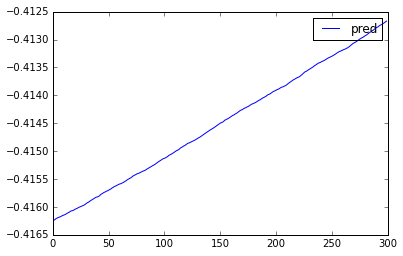

In [36]:
pred = get_stat("pred", dreamer.batch_optimizer.stats)
loss = get_stat("loss_train", dreamer.batch_optimizer.stats)
epoch = get_stat("epoch", dreamer.batch_optimizer.stats)
plt.plot(epoch, pred, label="pred")
#lt.plot(epoch, loss, label="loss")
plt.legend()

(-1.009823, 1.0096431)
(102.92917703533172, 124.68964307785035)


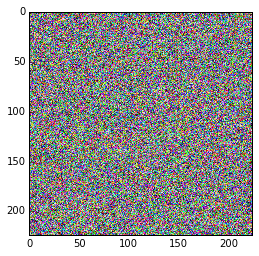

In [37]:
X_gen = dreamer.inputs.get_value().copy()
print(X_gen.min(), X_gen.max())
X_gen_ = X_gen
X_gen = X_gen +  mean_value[np.newaxis, :, np.newaxis, np.newaxis]
print(X_gen.min(), X_gen.max())
X_gen = X_gen.transpose((0, 3, 2, 1))
plt.imshow(X_gen[0])

In [ ]:
cl_index = list(reversed(np.argsort(predict(X_gen_.astype(np.float32))[0])))

In [ ]:
print(cl_index[0:10])